# Lorenz Experiment (Discovery of Governing Equations)

Import the libraries.

In [1]:
import itertools
import os
import sys

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import torch
from torch import nn
import torch.utils.data
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import the S-MNN module.

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '', '..', '..')))
from smnn import ode_forward

## Helper Functions

### Data Processing

In [3]:
def generate_lorenz(step_size: float, n_steps: int) -> np.ndarray:
    rho, sigma, beta = 28., 10., 8. / 3.

    def f(state, t):
        x, y, z = state
        return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

    state_0 = np.array([1., 1., 1.])
    time_steps = np.linspace(0., step_size * n_steps, n_steps)
    x_train = scipy.integrate.odeint(f, state_0, time_steps)
    return x_train

In [4]:
class LorenzDataset(torch.utils.data.Dataset):
    def __init__(self, step_size: float, n_steps_per_batch: int = 100, n_steps: int = 1000, device: torch.device = torch.device('cpu')):
        self.n_steps_per_batch = n_steps_per_batch
        self.n_steps = n_steps
        self.x_train: torch.Tensor = torch.as_tensor(generate_lorenz(step_size, n_steps + n_steps_per_batch), device=device)
        # tensor (n_steps, 3)

    def __len__(self) -> int:
        return self.n_steps

    def __getitem__(self, i: int) -> torch.Tensor:
        return self.x_train[i:i+self.n_steps_per_batch]

### Basis Computation

In [5]:
def get_basis_vars(n_vars: int = 3, polynomial_order: int = 2) -> tuple:
    return tuple(itertools.chain.from_iterable(
        itertools.combinations_with_replacement(range(n_vars), r=r)
        for r in range(polynomial_order + 1)
    ))  # tuple[tuple[int * ?] * 10]

In [6]:
def compute_basis(x: torch.Tensor, basis_vars: tuple) -> torch.Tensor:
    return torch.stack([x[..., basis_var].prod(dim=-1) for basis_var in basis_vars], dim=-1)  # (..., 10)

### Model Definition

In [7]:
class Model(nn.Module):
    def __init__(self, n_basis:int, n_step_per_batch: int, step_size: float, device: torch.device):
        super().__init__()
        dtype = torch.float64
        n_ind_dim = 3
        order = 2

        self.step_size = torch.full((1, 1, 1), step_size, dtype=dtype, device=device)
        self.coeffs = torch.zeros(1, n_ind_dim, 1, 1, 1, order+1, dtype=dtype, device=device)
        # use n_ind_dim instead of 1 to avoid repeating later (slow)
        self.coeffs[..., 1] = 1.

        mask = torch.ones(1, n_basis, n_ind_dim, dtype=dtype, device=device)  # (1, 10, 3)
        self.register_buffer('mask', mask)

        self.param_in = nn.Parameter(torch.randn(1, 64))
        self.param_net = nn.Sequential(
            nn.Linear(64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_basis * n_ind_dim),
            nn.Unflatten(dim=-1, unflattened_size=(n_basis, n_ind_dim)),
        )

        self.net = nn.Sequential(
            nn.Flatten(start_dim=-2, end_dim=-1),
            nn.Linear(n_step_per_batch * n_ind_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_step_per_batch * n_ind_dim),
            nn.Unflatten(dim=-1, unflattened_size=(n_step_per_batch, n_ind_dim))
        )

    def update_mask(self, mask: torch.Tensor) -> None:
        self.mask *= mask

    def get_xi(self) -> torch.Tensor:
        return self.param_net(self.param_in) * self.mask  # (1, 10, 3)

    def forward(self, batch_in: torch.Tensor)-> tuple[torch.Tensor, torch.Tensor]:
        var = self.net(batch_in)  # (bs, 50, 3)
        rhs = compute_basis(var, get_basis_vars()) @ self.get_xi()  # (bs, 50, 3)

        u = ode_forward(
            self.coeffs[None, :, :, 0],  # (1, 1, 3, 1, 1, 3)
            rhs.transpose(0, 1)[..., None],  # (50, bs, 3, 1)
            var[None, :, 0, :, None, None],  # (1, bs, 3, 1, 1)
            self.step_size,
            n_steps=batch_in.size(-2),
            is_step_dim_first=True,
            enable_central_smoothness=False,
            frozen_lhs_cache_version=1,
        )  # (50, bs, 3, 1, 3)
        x0 = u[..., 0, 0].transpose(0, 1)

        return x0, var

### Printing and Plotting

In [8]:
def print_eq(model: Model, basis_vars: tuple) -> None:
    xi = model.get_xi().detach().squeeze()
    n_basis, dim = xi.shape
    basis_vars = ['1'] + ['*'.join([f'x{v}' for v in basis_var]) for basis_var in basis_vars[1:]]
    for i in range(dim):
        k = f'dx{i}'
        v = "0 "
        for j in range(n_basis):
            v += f' + {xi[j, i].item()} * {basis_vars[j]}'
        print(f'{k} = {v}')

In [9]:
def plot_lorenz(data: np.ndarray) -> None:
    f = plt.figure(figsize=(6, 4))
    plt.plot(data[:, 0], data[:, 2], label='Trajectory')
    plt.plot(data[0, 0], data[0, 2], 'ko', label='Initialization')
    plt.xlim(-20., 20.)
    plt.ylim(0., 50.)
    plt.tick_params(axis='both', which='both', length=0.)
    plt.grid()
    # plt.gca().set_aspect('equal')
    plt.legend(loc='upper center', framealpha=1.)
    plt.gca().set_facecolor((1., 1., 1., 1.))
    plt.gcf().set_facecolor((1., 1., 1., 0.))
    plt.tight_layout()
    plt.show()
    plt.close(f)

In [10]:
def simulate(n_steps: int, step: float, model: Model, basis_vars: tuple) -> np.ndarray:
    # simulate learned equation
    xi = model.get_xi()[0].detach().t().cpu().numpy()  # (1, 10, 3) (3, 10)

    def f(state, t):
        return xi @ np.array([np.prod(state[basis_var,]) for basis_var in basis_vars])

    state_0 = np.array([1., 1., 1.])
    time_steps = np.linspace(0., step * n_steps, n_steps)
    x_sim = scipy.integrate.odeint(f, state_0, time_steps)
    return x_sim

## Running Experiment

Set arguments.

In [11]:
n_steps = 10000
n_steps_per_batch = 50
step_size = 1e-2
batch_size = 512
threshold = .1  # weights less than threshold (absolute) are set to 0 after each optimization step.
max_iter = 10  # number of optimize and threshold cycles

learning_rate = 5e-4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Generate train data.

In [12]:
ds = LorenzDataset(step_size=step_size, n_steps=n_steps, n_steps_per_batch=n_steps_per_batch)
train_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

Plot train data.

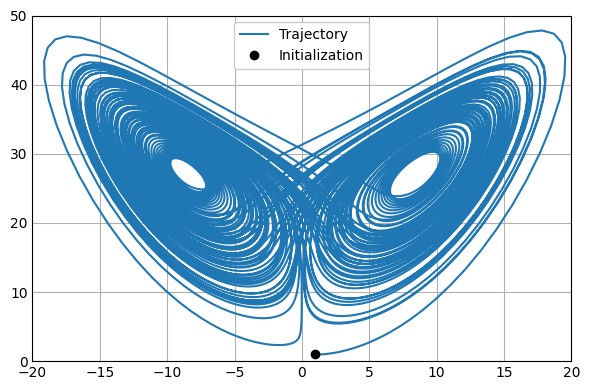

In [13]:
plot_lorenz(ds.x_train.cpu().numpy())

Initialize the model.

In [14]:
basis_vars = get_basis_vars()
model = Model(n_basis=len(basis_vars), n_step_per_batch=n_steps_per_batch, step_size=step_size, device=device)
model.to(dtype=torch.double, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Optimize and threshold cycle.

dx0 = 0  + 0.048186220563987 * 1 + 0.12058572915300786 * x0 + 0.04006460775779068 * x1 + 0.004416973590482827 * x2 + 0.14441720540340455 * x0*x0 + 0.2165338325582051 * x0*x1 + -0.030506186419604613 * x0*x2 + -0.08557855081075483 * x1*x1 + -0.1410859860645931 * x1*x2 + 0.1450623147181343 * x2*x2
dx1 = 0  + -0.07666521885687046 * 1 + 0.16143281859983152 * x0 + -0.04554369956218604 * x1 + 0.20315959392203745 * x2 + 0.12901646274772174 * x0*x0 + -0.11403069316350906 * x0*x1 + -0.011845378699506956 * x0*x2 + -0.041431361880314 * x1*x1 + -0.08263057983610927 * x1*x2 + 0.09540455763701382 * x2*x2
dx2 = 0  + -0.05251948779429381 * 1 + -0.017387332096679656 * x0 + 0.09988735534615067 * x1 + -0.001992449966689097 * x2 + 0.260812324801046 * x0*x0 + 0.037117451674801016 * x0*x1 + -0.12789899155501 * x0*x2 + -0.0805356682589904 * x1*x1 + 0.24479840575411693 * x1*x2 + -0.02503440559779906 * x2*x2


/tmp/ipykernel_129399/3322347810.py:10: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  x_sim = scipy.integrate.odeint(f, state_0, time_steps)


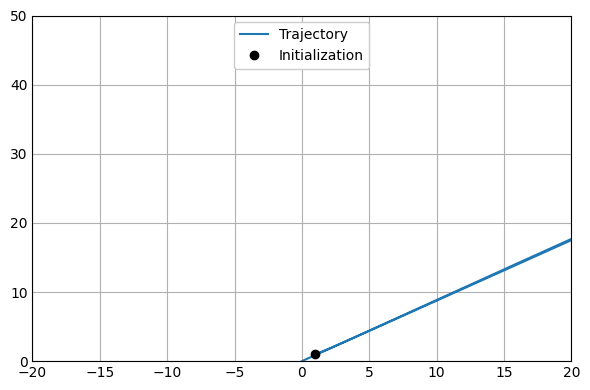

Optimizer iteration 1/10


iter 1 epoch 399 loss 0.17942371362084203 xloss 0.11794275430723482: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:21<00:00,  2.83it/s]


dx0 = 0  + -0.1560628501773373 * 1 + -4.160572877656097 * x0 + 6.217382852554253 * x1 + -0.09112203896606587 * x2 + -0.1984371947019331 * x0*x0 + 0.24052660222445013 * x0*x1 + -0.16777084390488578 * x0*x2 + -0.08377114942352898 * x1*x1 + 0.10885484401682599 * x1*x2 + 0.010806022086623488 * x2*x2
dx1 = 0  + 0.26951991089900856 * 1 + 14.399890070519868 * x0 + 8.452859206614507 * x1 + 0.376430801746049 * x2 + 0.23423397471095514 * x0*x0 + -0.2542855620012432 * x0*x1 + -0.583382797295006 * x0*x2 + 0.07078567314446141 * x1*x1 + -0.2966357943314568 * x1*x2 + -0.021932003869789246 * x2*x2
dx2 = 0  + -3.3916091700358155 * 1 + -0.35618909446350405 * x0 + 0.1929628680007434 * x1 + -1.7313600693488802 * x2 + 0.2910094043630463 * x0*x0 + 0.6587812201255624 * x0*x1 + 0.011134079892931099 * x0*x2 + 0.115655003176586 * x1*x1 + -0.0072244851232248775 * x1*x2 + -0.03854355417855236 * x2*x2


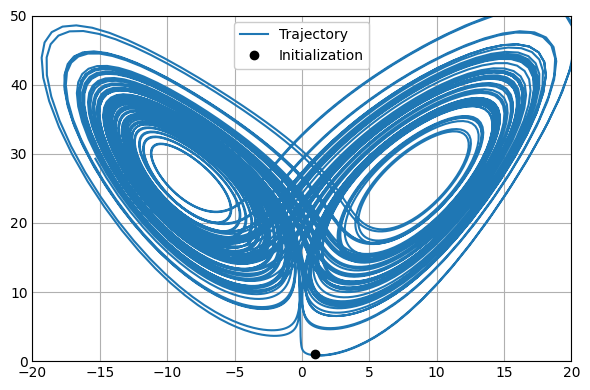

Optimizer iteration 2/10


iter 2 epoch 399 loss 0.03543651552248463 xloss 0.016899049700356192: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:19<00:00,  2.87it/s]


dx0 = 0  + 0.09435590117220455 * 1 + -8.044793290084773 * x0 + 8.739764063397756 * x1 + -0.0 * x2 + -0.0006533985831634181 * x0*x0 + 0.000404520148126598 * x0*x1 + -0.05138668045433302 * x0*x2 + -0.0 * x1*x1 + 0.0315024495122323 * x1*x2 + 0.0 * x2*x2
dx1 = 0  + 0.8556785212767011 * 1 + 20.34354102469387 * x0 + 4.225004246623845 * x1 + -0.05150819324852965 * x2 + 0.012733957523830686 * x0*x0 + -0.010035615991436094 * x0*x1 + -0.7676470404706138 * x0*x2 + 0.0 * x1*x1 + -0.15942503309420086 * x1*x2 + -0.0 * x2*x2
dx2 = 0  + 0.49530419826408945 * 1 + 0.0042227493605418165 * x0 + -0.00842752727829572 * x1 + -2.709851752237306 * x2 + 0.010298120342547162 * x0*x0 + 0.9612119733041645 * x0*x1 + -0.0 * x0*x2 + 0.030408149690893962 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2


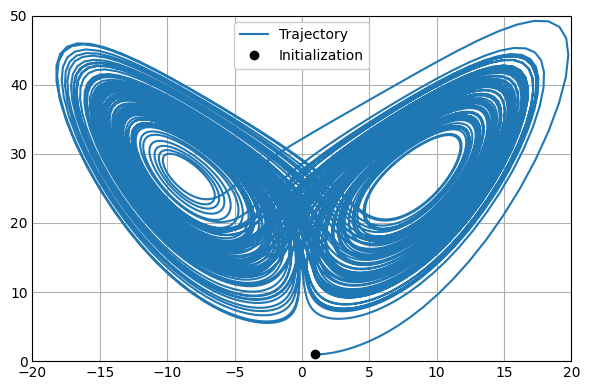

Optimizer iteration 3/10


iter 3 epoch 399 loss 0.04801192064845075 xloss 0.03913768177610057: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:18<00:00,  2.88it/s]


dx0 = 0  + 0.0 * 1 + -9.860023028569492 * x0 + 9.865185434777427 * x1 + -0.0 * x2 + 0.0 * x0*x0 + -0.0 * x0*x1 + -0.0 * x0*x2 + -0.0 * x1*x1 + 0.0 * x1*x2 + 0.0 * x2*x2
dx1 = 0  + -0.05746795806665571 * 1 + 24.453811453799407 * x0 + 1.1377424517359833 * x1 + -0.0 * x2 + 0.0 * x0*x0 + 0.0 * x0*x1 + -0.8974784192040773 * x0*x2 + -0.0 * x1*x1 + -0.06037566439689892 * x1*x2 + -0.0 * x2*x2
dx2 = 0  + 0.6577699249291623 * 1 + 0.0 * x0 + -0.0 * x1 + -2.6983815386200662 * x2 + -0.0 * x0*x0 + 1.004193270918811 * x0*x1 + -0.0 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2


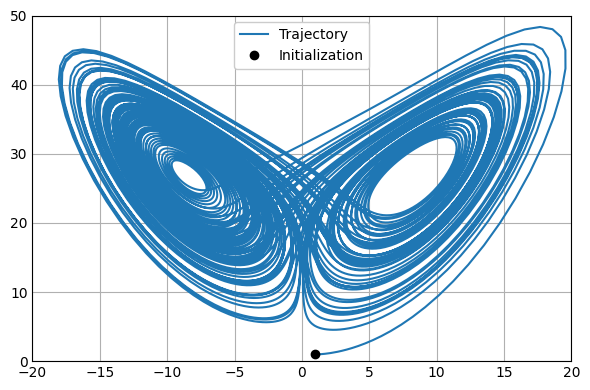

Optimizer iteration 4/10


iter 4 epoch 399 loss 0.0029627299210422692 xloss 0.0014853949973276444: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:19<00:00,  2.87it/s]


dx0 = 0  + 0.0 * 1 + -10.04813691535888 * x0 + 10.049745410676532 * x1 + -0.0 * x2 + 0.0 * x0*x0 + -0.0 * x0*x1 + -0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2
dx1 = 0  + -0.0 * 1 + 27.18420174217999 * x0 + -0.7693704092098494 * x1 + -0.0 * x2 + 0.0 * x0*x0 + 0.0 * x0*x1 + -0.9790843486685923 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2
dx2 = 0  + -0.08512543111764638 * 1 + 0.0 * x0 + -0.0 * x1 + -2.663740486177842 * x2 + 0.0 * x0*x0 + 0.9984605079833517 * x0*x1 + -0.0 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2


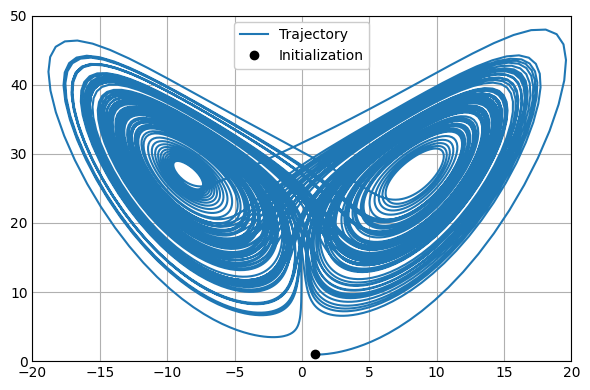

Optimizer iteration 5/10


iter 5 epoch 399 loss 0.003999656678838797 xloss 0.003040581251799677: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:17<00:00,  2.90it/s]


dx0 = 0  + 0.0 * 1 + -10.028792751189924 * x0 + 10.02798320408389 * x1 + -0.0 * x2 + 0.0 * x0*x0 + 0.0 * x0*x1 + -0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2
dx1 = 0  + -0.0 * 1 + 27.508370842876957 * x0 + -0.8648705099146249 * x1 + -0.0 * x2 + 0.0 * x0*x0 + -0.0 * x0*x1 + -0.9869135500316445 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2
dx2 = 0  + -0.0 * 1 + 0.0 * x0 + 0.0 * x1 + -2.6666674647603066 * x2 + 0.0 * x0*x0 + 0.9987485644831633 * x0*x1 + 0.0 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2


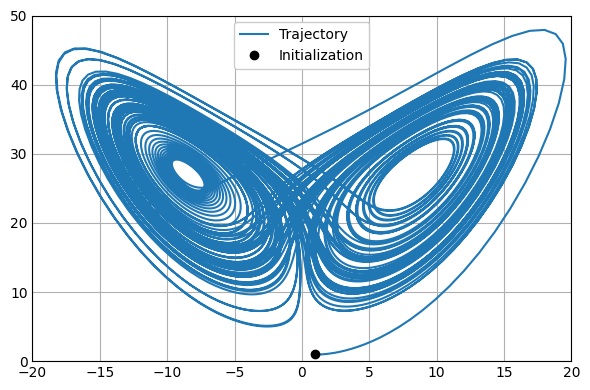

Optimizer iteration 6/10


iter 6 epoch 399 loss 0.01617789806514839 xloss 0.012400579282116707: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:19<00:00,  2.87it/s]


dx0 = 0  + 0.0 * 1 + -9.99029071751957 * x0 + 9.996815081759308 * x1 + -0.0 * x2 + 0.0 * x0*x0 + 0.0 * x0*x1 + -0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2
dx1 = 0  + -0.0 * 1 + 27.43783243612114 * x0 + -0.8396495206628285 * x1 + 0.0 * x2 + 0.0 * x0*x0 + -0.0 * x0*x1 + -0.9839009652599999 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2
dx2 = 0  + -0.0 * 1 + -0.0 * x0 + 0.0 * x1 + -2.666211676525294 * x2 + 0.0 * x0*x0 + 0.9977794638874519 * x0*x1 + 0.0 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2


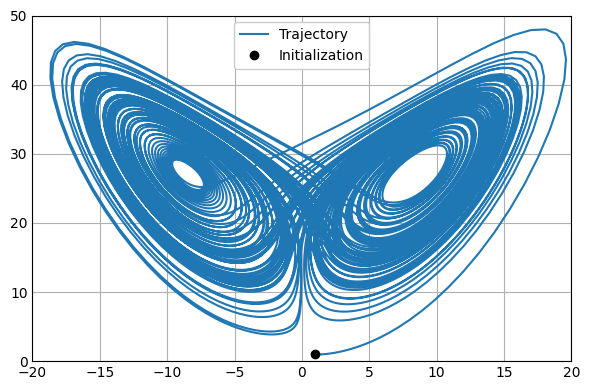

Optimizer iteration 7/10


iter 7 epoch 399 loss 0.0019626471930303917 xloss 0.0010550461364830558: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:20<00:00,  2.85it/s]


dx0 = 0  + 0.0 * 1 + -9.999170110654319 * x0 + 9.997906204125405 * x1 + -0.0 * x2 + -0.0 * x0*x0 + 0.0 * x0*x1 + -0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2
dx1 = 0  + -0.0 * 1 + 27.471677196629695 * x0 + -0.8423296097411603 * x1 + 0.0 * x2 + 0.0 * x0*x0 + -0.0 * x0*x1 + -0.9866745929989914 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2
dx2 = 0  + -0.0 * 1 + -0.0 * x0 + 0.0 * x1 + -2.664843569809879 * x2 + 0.0 * x0*x0 + 0.9986545711758043 * x0*x1 + 0.0 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2


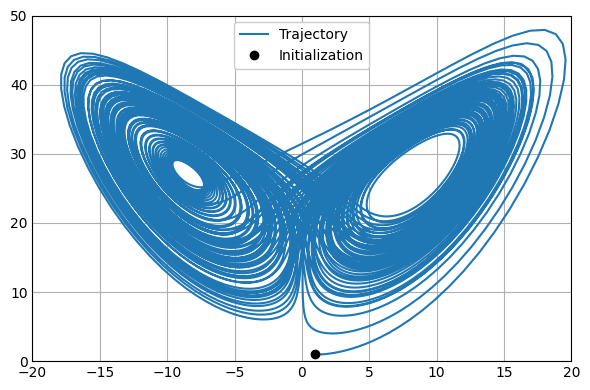

Optimizer iteration 8/10


iter 8 epoch 399 loss 0.0013503471327502591 xloss 0.0006897028023668918: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:21<00:00,  2.83it/s]


dx0 = 0  + 0.0 * 1 + -10.015188406931136 * x0 + 10.015420996319701 * x1 + -0.0 * x2 + -0.0 * x0*x0 + 0.0 * x0*x1 + -0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2
dx1 = 0  + -0.0 * 1 + 27.596276151685256 * x0 + -0.8880744430671538 * x1 + 0.0 * x2 + 0.0 * x0*x0 + -0.0 * x0*x1 + -0.9898073338257376 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2
dx2 = 0  + -0.0 * 1 + -0.0 * x0 + 0.0 * x1 + -2.666019039412308 * x2 + 0.0 * x0*x0 + 0.9985828595022764 * x0*x1 + 0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2


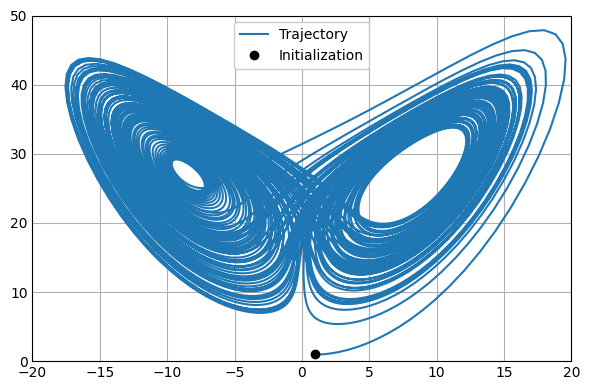

Optimizer iteration 9/10


iter 9 epoch 399 loss 0.03223716827340583 xloss 0.025789142204881158: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:20<00:00,  2.85it/s]


dx0 = 0  + 0.0 * 1 + -9.916958224354639 * x0 + 9.922654386257742 * x1 + -0.0 * x2 + -0.0 * x0*x0 + 0.0 * x0*x1 + -0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2
dx1 = 0  + -0.0 * 1 + 27.391461003242945 * x0 + -0.8763738145405611 * x1 + 0.0 * x2 + 0.0 * x0*x0 + -0.0 * x0*x1 + -0.9826793594310719 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2
dx2 = 0  + -0.0 * 1 + -0.0 * x0 + 0.0 * x1 + -2.6514149763369366 * x2 + 0.0 * x0*x0 + 0.9956855612771691 * x0*x1 + 0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2


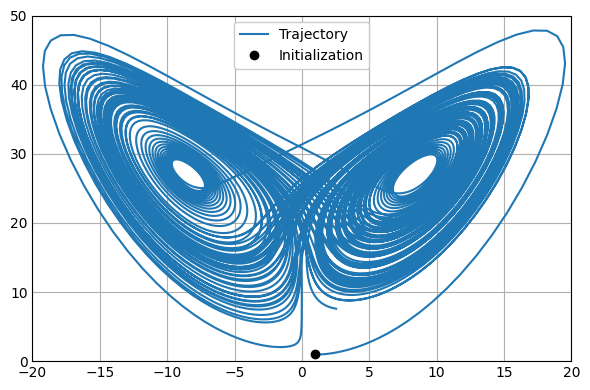

Optimizer iteration 10/10


iter 10 epoch 399 loss 0.0018020756375573157 xloss 0.000984622609554693: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:18<00:00,  2.88it/s]


dx0 = 0  + 0.0 * 1 + -9.989880097860121 * x0 + 9.990050087613756 * x1 + -0.0 * x2 + -0.0 * x0*x0 + 0.0 * x0*x1 + -0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2
dx1 = 0  + -0.0 * 1 + 27.707953172975593 * x0 + -0.9216606832986763 * x1 + 0.0 * x2 + 0.0 * x0*x0 + -0.0 * x0*x1 + -0.9923309725355407 * x0*x2 + 0.0 * x1*x1 + -0.0 * x1*x2 + -0.0 * x2*x2
dx2 = 0  + -0.0 * 1 + -0.0 * x0 + 0.0 * x1 + -2.664228514921056 * x2 + 0.0 * x0*x0 + 0.9993324591929487 * x0*x1 + 0.0 * x0*x2 + -0.0 * x1*x1 + -0.0 * x1*x2 + 0.0 * x2*x2


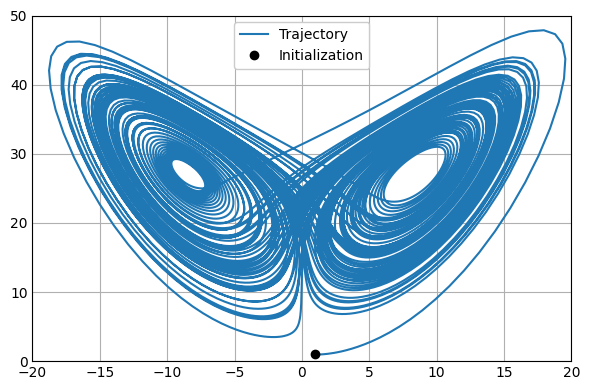

In [15]:
for step in range(max_iter + 1):
    if step > 0:
        print(f'Optimizer iteration {step}/{max_iter}')

        # threshold
        if step > 1:
            xi = model.get_xi()
            mask = (xi.abs() > threshold).float()
            model.update_mask(mask)  # set mask

        n_epochs = 400
        with tqdm(total=n_epochs) as pbar:
            for epoch in range(n_epochs):
                pbar.update(1)
                for i, batch_in in enumerate(train_loader):
                    batch_in = batch_in.to(device)
                    x0, var = model(batch_in)

                    x_loss = (x0 - batch_in).pow(2).mean()
                    loss = x_loss + (var - batch_in).pow(2).mean()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                stats = {'iter': step, 'epoch': epoch, 'loss': loss.item(), 'xloss': x_loss.item()}
                pbar.set_description(' '.join([f'{k} {v}' for k, v in stats.items()]))
    print_eq(model, basis_vars)
    x_sim = simulate(n_steps, step_size, model, basis_vars)  # (10000, 3)
    plot_lorenz(x_sim)